<a href="https://colab.research.google.com/github/kingaber/3DImagingHabitats/blob/main/keras_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification of heart disease patients

In [3]:
#setup libraries
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
#load preprocessed, unbalanced data
from google.colab import drive
drive.mount('/content/drive/')
file = tf.keras.utils
data_imp = pd.read_csv('/content/drive/My Drive/ColabNotebooks/data_imputed.csv')
data_imp.head()


Mounted at /content/drive/


,survival,still_alive,age_at_heart_attack,pericardial_effusion,fractional_shortening,epss,lvdd,wall_motion_index,outcome
0,11,0,71,0,0.260,9.000,4.600,1.00,0
1,19,0,72,0,0.380,6.000,4.100,1.70,1
2,16,0,55,0,0.260,4.000,3.420,1.00,1
3,57,0,60,0,0.253,12.062,4.603,1.45,1
4,26,0,68,0,0.260,5.000,4.310,1.00,1


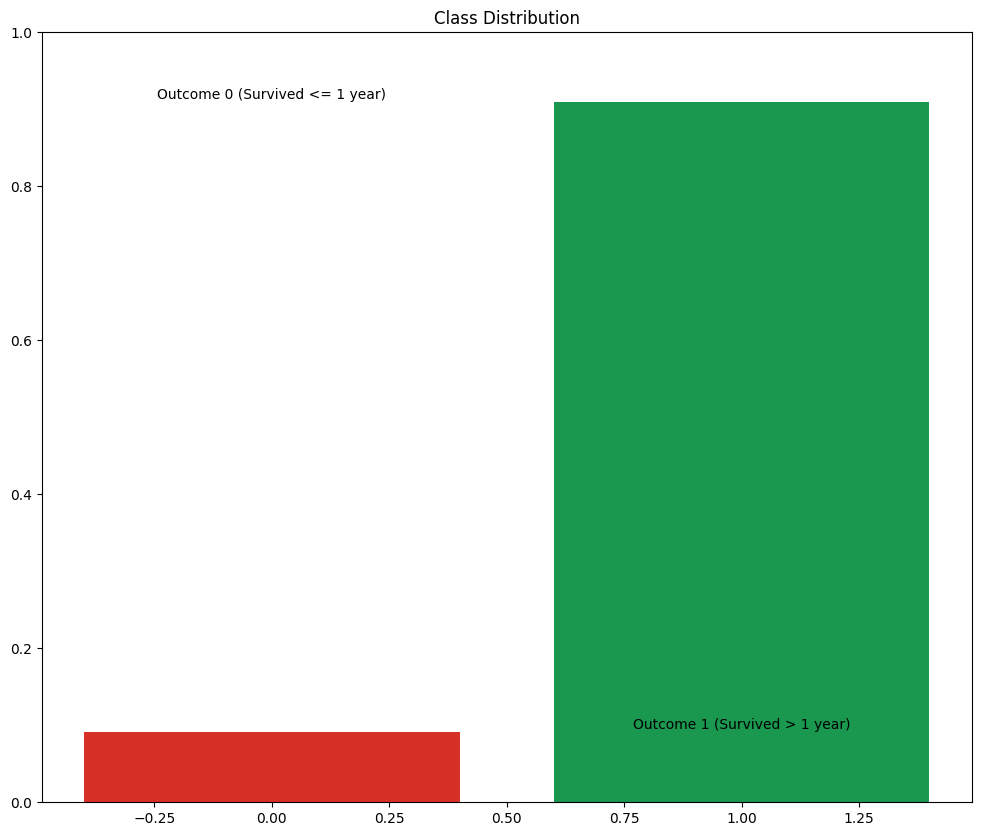

In [5]:
# Calculate the class distribution and normalize it to get proportions
class_distribution = data_imp['outcome'].value_counts(normalize=True)
colors2 = ["#1a9850","#d73027"]
plt.bar(class_distribution.index, class_distribution.values, color=colors2)
plt.ylim(0, 1)
plt.title("Class Distribution")
# Add labels for the bars
for i, v in enumerate(class_distribution.values):
    plt.text(i, v, f"Outcome {i} ({'Survived <= 1 year' if i == 0 else 'Survived > 1 year'})", ha='center', va='bottom')
plt.show()

In [6]:
#split data
train_df, val_df = train_test_split(data_imp, test_size=0.2, stratify=data_imp['outcome'], random_state=42)
train_features = np.array(train_df.iloc[:, 2:8])
val_features =  np.array(val_df.iloc[:, 2:8])

train_labels = np.array(train_df['outcome'])
val_labels = np.array(val_df['outcome'])

#scale features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)

Define model and metrics

In [7]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

Baseline model

In [8]:
EPOCHS = 100
BATCH_SIZE = 8

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=15,
    mode='max',
    restore_best_weights=True)

model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                112       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 129 (516.00 Byte)
Trainable params: 129 (516.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
model.predict(train_features)

3/3 [==============================] - 1s 9ms/step


array([[0.7384594 ],
       [0.24219011],
       [0.25084186],
       [0.5206686 ],
       [0.6444628 ],
       [0.23478884],
       [0.6188991 ],
       [0.50349873],
       [0.53488165],
       [0.42887482],
       [0.19489454],
       [0.373834  ],
       [0.36398357],
       [0.29457578],
       [0.63160884],
       [0.285201  ],
       [0.177706  ],
       [0.23650436],
       [0.51071125],
       [0.3338152 ],
       [0.32314295],
       [0.40299463],
       [0.28838658],
       [0.64453083],
       [0.1994692 ],
       [0.39978465],
       [0.27787387],
       [0.4152755 ],
       [0.33025008],
       [0.27324477],
       [0.27682948],
       [0.41578177],
       [0.229926  ],
       [0.31899664],
       [0.23016106],
       [0.26857093],
       [0.40210313],
       [0.45918053],
       [0.35223544],
       [0.41331574],
       [0.20579708],
       [0.24328387],
       [0.26207387],
       [0.39815623],
       [0.5355556 ],
       [0.3637117 ],
       [0.4303827 ],
       [0.413

In [10]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

Initial weights and train the model

In [11]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
9/9 [==============================] - 3s 98ms/step - loss: 1.0893 - cross entropy: 1.0893 - Brier score: 0.4108 - tp: 12.0000 - fp: 3.0000 - tn: 3.0000 - fn: 52.0000 - accuracy: 0.2143 - precision: 0.8000 - recall: 0.1875 - auc: 0.4049 - prc: 0.8621 - val_loss: 1.0407 - val_cross entropy: 1.0407 - val_Brier score: 0.4032 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 13.0000 - val_accuracy: 0.2778 - val_precision: 1.0000 - val_recall: 0.1875 - val_auc: 0.3750 - val_prc: 0.8898
Epoch 2/100
9/9 [==============================] - 0s 16ms/step - loss: 1.1311 - cross entropy: 1.1311 - Brier score: 0.4281 - tp: 12.0000 - fp: 2.0000 - tn: 4.0000 - fn: 52.0000 - accuracy: 0.2286 - precision: 0.8571 - recall: 0.1875 - auc: 0.3828 - prc: 0.8599 - val_loss: 1.0074 - val_cross entropy: 1.0074 - val_Brier score: 0.3900 - val_tp: 3.0000 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 13.0000 - val_accuracy: 0.2778 - val_precision: 1.0000 - val_recall: 0.1875 - val_auc:

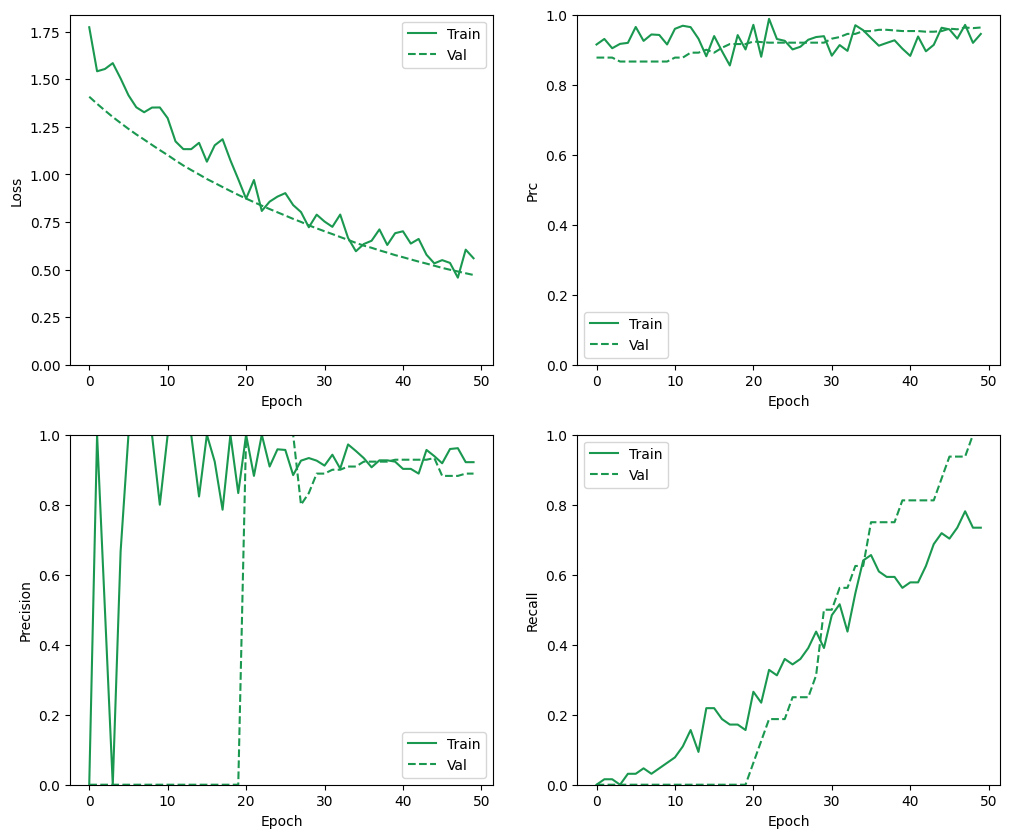

In [ ]:
#check training
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(baseline_history)

In [14]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
print(train_predictions_baseline)


9/9 [==============================] - 0s 2ms/step
[[0.93898   ]
 [0.50619954]
 [0.49065587]
 [0.6734751 ]
 [0.85927033]
 [0.57244706]
 [0.73174745]
 [0.7027719 ]
 [0.8019975 ]
 [0.6562938 ]
 [0.60687965]
 [0.54288816]
 [0.5681171 ]
 [0.6512735 ]
 [0.8068029 ]
 [0.50853014]
 [0.7394341 ]
 [0.44621083]
 [0.7781523 ]
 [0.60442096]
 [0.47041953]
 [0.6981762 ]
 [0.5413613 ]
 [0.8105843 ]
 [0.5291349 ]
 [0.67393273]
 [0.65664965]
 [0.6615673 ]
 [0.5236001 ]
 [0.57870424]
 [0.4633128 ]
 [0.61167717]
 [0.4442042 ]
 [0.5090016 ]
 [0.43254095]
 [0.71129787]
 [0.60164046]
 [0.6363692 ]
 [0.5855381 ]
 [0.6634985 ]
 [0.5089162 ]
 [0.4788674 ]
 [0.5941931 ]
 [0.748685  ]
 [0.84689987]
 [0.53401333]
 [0.66022927]
 [0.60987717]
 [0.5075793 ]
 [0.57462823]
 [0.46874434]
 [0.6448719 ]
 [0.6065676 ]
 [0.51371175]
 [0.5855611 ]
 [0.53895146]
 [0.62193346]
 [0.66267043]
 [0.73929906]
 [0.50636923]
 [0.5865445 ]
 [0.6298186 ]
 [0.3915967 ]
 [0.412568  ]
 [0.6219408 ]
 [0.4898829 ]
 [0.67248476]
 [0.4845735

In [15]:
results = model.evaluate(train_features, train_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.5889679193496704
cross entropy :  0.5889679193496704
Brier score :  0.1991855502128601
tp :  51.0
fp :  6.0
tn :  0.0
fn :  13.0
accuracy :  0.7285714149475098
precision :  0.8947368264198303
recall :  0.796875
auc :  0.3697916567325592
prc :  0.8688144683837891



Legitimate Transactions Detected (True Negatives):  0
Legitimate Transactions Incorrectly Detected (False Positives):  6
Fraudulent Transactions Missed (False Negatives):  2
Fraudulent Transactions Detected (True Positives):  62
Total Fraudulent Transactions:  64


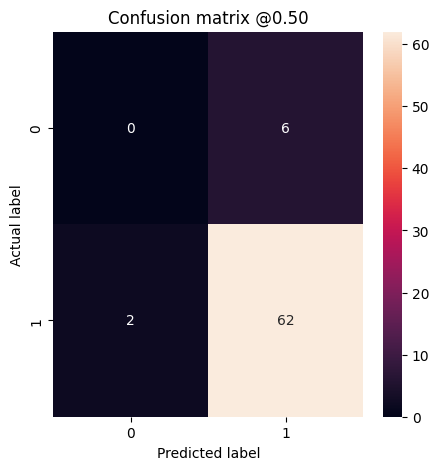

In [ ]:
plot_cm(train_labels, train_predictions_baseline, threshold=0.5)

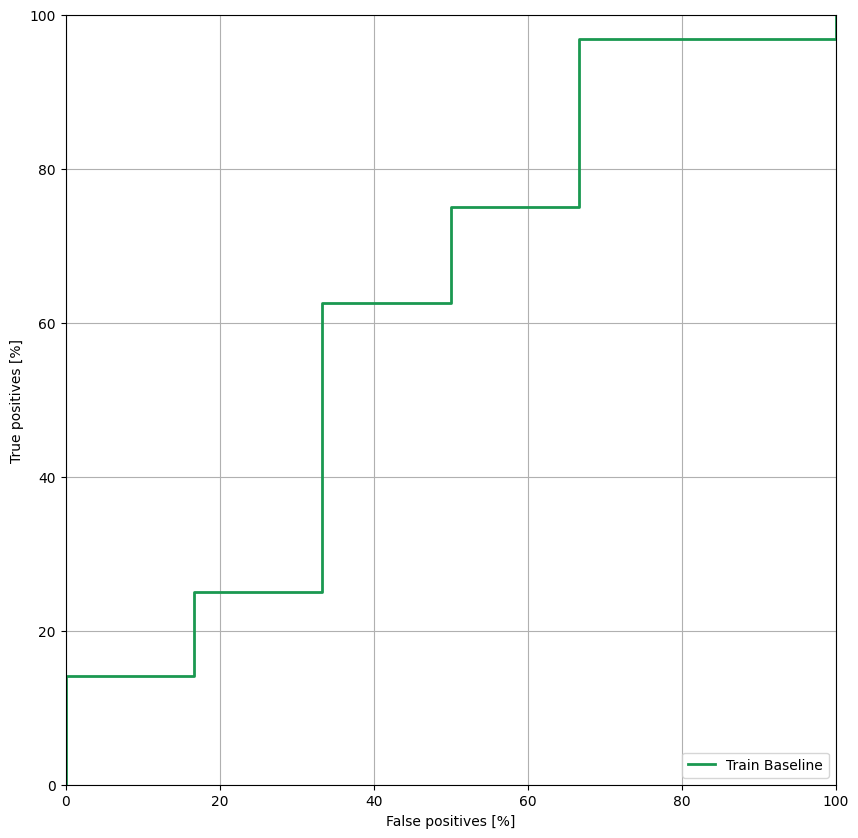

In [ ]:
# plot ROC
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plt.legend(loc='lower right');

In [ ]:
# Calculate class weights
total_samples = len(train_labels)
class_weight = {
    0: 0.8,  # Weight for class 0
    1: 0.5  # Weight for class 1
}
print(class_weight)
print(total_samples)

{0: 0.8, 1: 0.5}
70


In [ ]:
# Train model with weights
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

Epoch 1/100
1/9 [==>...........................] - ETA: 45s - loss: 0.6647 - cross entropy: 0.6979 - Brier score: 0.2508 - tp: 39.0000 - fp: 2.0000 - tn: 4.0000 - fn: 33.0000 - accuracy: 0.5513 - precision: 0.9512 - recall: 0.5417 - auc: 0.6088 - prc: 0.9511

Exception ignored in: <function _xla_gc_callback at 0x7955cd591cf0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


9/9 [==============================] - 63s 7s/step - loss: 0.8464 - cross entropy: 1.1550 - Brier score: 0.3931 - tp: 39.0000 - fp: 2.0000 - tn: 10.0000 - fn: 89.0000 - accuracy: 0.3500 - precision: 0.9512 - recall: 0.3047 - auc: 0.5960 - prc: 0.9399 - val_loss: 1.4068 - val_cross entropy: 1.4068 - val_Brier score: 0.5367 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.1111 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5469 - val_prc: 0.8775
Epoch 2/100
9/9 [==============================] - 0s 13ms/step - loss: 0.7584 - cross entropy: 1.5052 - Brier score: 0.5248 - tp: 2.0000 - fp: 0.0000e+00 - tn: 6.0000 - fn: 62.0000 - accuracy: 0.1143 - precision: 1.0000 - recall: 0.0312 - auc: 0.6159 - prc: 0.9465 - val_loss: 1.3710 - val_cross entropy: 1.3710 - val_Brier score: 0.5262 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 2.0000 - val_fn: 16.0000 - val_accuracy: 0.1111 - val_precision: 0.0000e+00 - val_recall: 0.0000

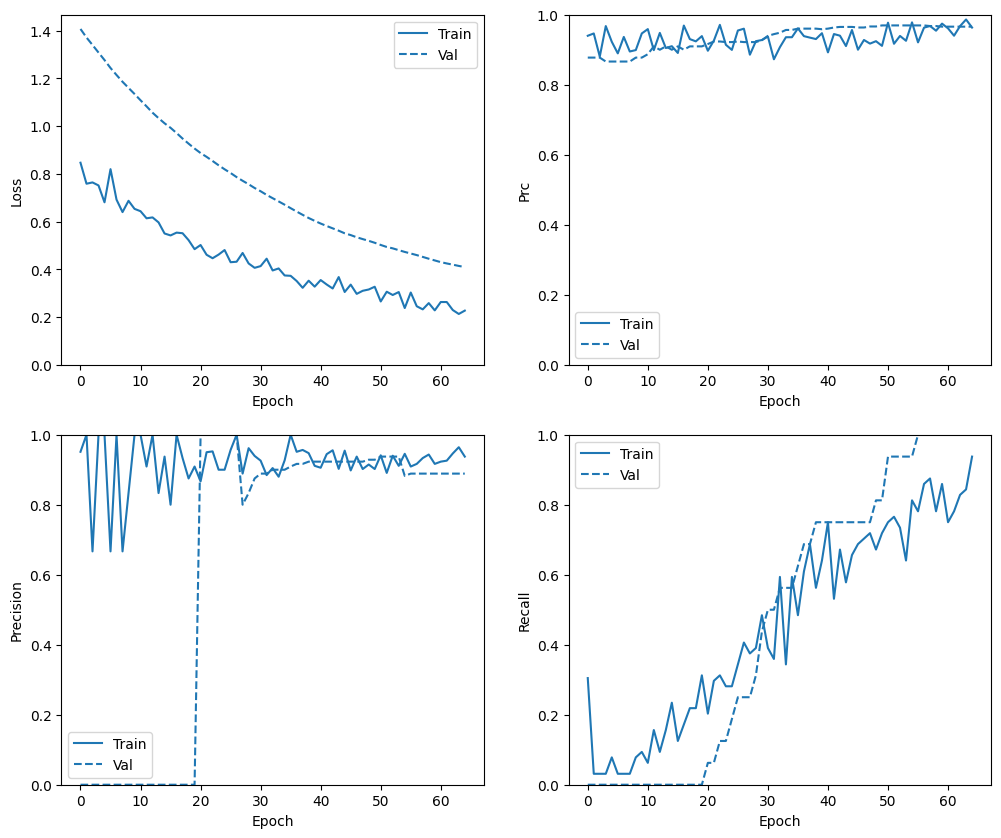

In [ ]:
plot_metrics(weighted_history)


In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)

9/9 [==============================] - 0s 2ms/step


loss :  0.6257815361022949
cross entropy :  0.6257815361022949
Brier score :  0.21806848049163818
tp :  39.0
fp :  2.0
tn :  4.0
fn :  25.0
accuracy :  0.6142857074737549
precision :  0.9512194991111755
recall :  0.609375
auc :  0.6822916865348816
prc :  0.9549090266227722

Legitimate Transactions Detected (True Negatives):  4
Legitimate Transactions Incorrectly Detected (False Positives):  2
Fraudulent Transactions Missed (False Negatives):  25
Fraudulent Transactions Detected (True Positives):  39
Total Fraudulent Transactions:  64


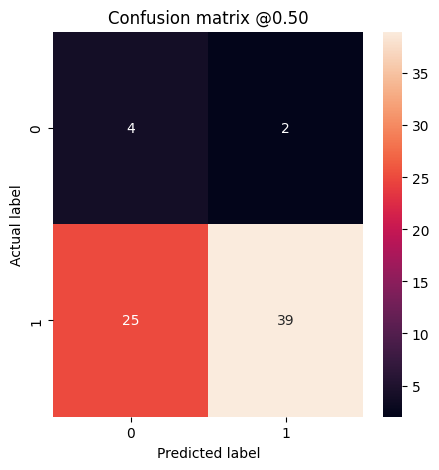

In [ ]:
weighted_results = weighted_model.evaluate(train_features, train_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(train_labels, train_predictions_weighted, threshold=0.5)

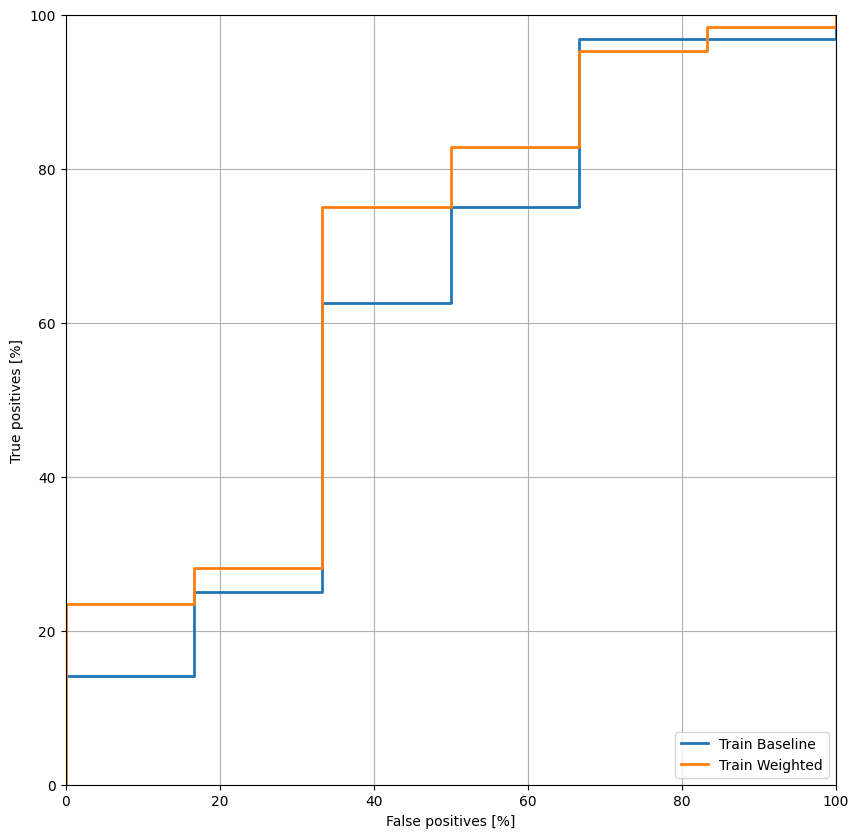

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])


plt.legend(loc='lower right');

Oversampling

In [ ]:
# create labels
bool_train_labels = train_labels != 0

pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [ ]:
# oversample using tf
BUFFER_SIZE = 50

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [ ]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [ 1.16648984 -0.43178777  1.22606812 -1.50773287 -0.10325655 -0.77613481]

Label:  1


In [ ]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.5


To use this dataset, we need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [ ]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

2.0

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/50
2/2 [==============================] - 5s 2s/step - loss: 0.5781 - cross entropy: 0.7619 - Brier score: 0.2796 - tp: 6.0000 - fp: 4.0000 - tn: 8.0000 - fn: 16.0000 - accuracy: 0.4118 - precision: 0.6000 - recall: 0.2727 - auc: 0.5720 - prc: 0.6847 - val_loss: 0.9289 - val_cross entropy: 0.9289 - val_Brier score: 0.3507 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 1.0000 - val_fn: 14.0000 - val_accuracy: 0.1667 - val_precision: 0.6667 - val_recall: 0.1250 - val_auc: 0.5625 - val_prc: 0.8916
Epoch 2/50
2/2 [==============================] - 0s 168ms/step - loss: 0.7049 - cross entropy: 0.7049 - Brier score: 0.2510 - tp: 2.0000 - fp: 4.0000 - tn: 6.0000 - fn: 4.0000 - accuracy: 0.5000 - precision: 0.3333 - recall: 0.3333 - auc: 0.4917 - prc: 0.3423 - val_loss: 0.9311 - val_cross entropy: 0.9311 - val_Brier score: 0.3513 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 1.0000 - val_fn: 14.0000 - val_accuracy: 0.1667 - val_precision: 0.6667 - val_recall: 0.1250 - val_auc: 0.5625 - val_

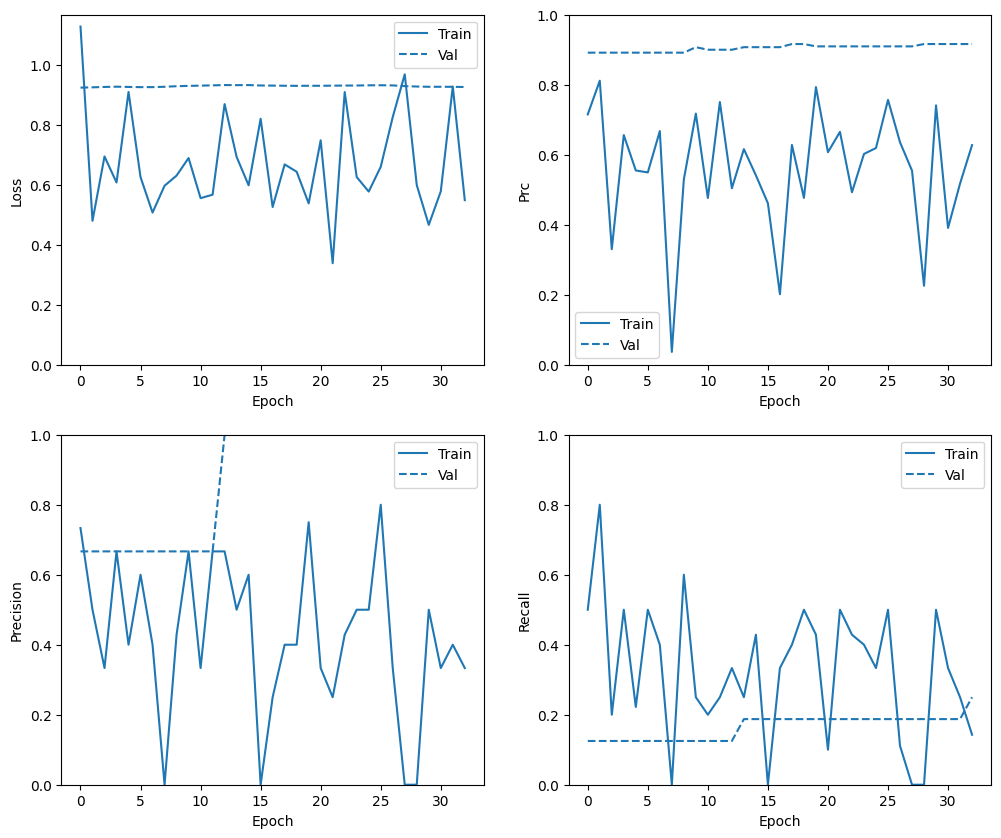

In [ ]:
plot_metrics(resampled_history)

In [ ]:
#retrain to prevent overfitting
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = len(train_labels) // BATCH_SIZE,
    epochs=50,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/50
8/8 [==============================] - 3s 143ms/step - loss: 0.8815 - cross entropy: 0.7160 - Brier score: 0.2460 - tp: 32.0000 - fp: 25.0000 - tn: 42.0000 - fn: 29.0000 - accuracy: 0.5781 - precision: 0.5614 - recall: 0.5246 - auc: 0.6346 - prc: 0.6124 - val_loss: 0.9221 - val_cross entropy: 0.9221 - val_Brier score: 0.3482 - val_tp: 2.0000 - val_fp: 1.0000 - val_tn: 1.0000 - val_fn: 14.0000 - val_accuracy: 0.1667 - val_precision: 0.6667 - val_recall: 0.1250 - val_auc: 0.5625 - val_prc: 0.8916
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 0.7511 - cross entropy: 0.7511 - Brier score: 0.2593 - tp: 7.0000 - fp: 4.0000 - tn: 28.0000 - fn: 25.0000 - accuracy: 0.5469 - precision: 0.6364 - recall: 0.2188 - auc: 0.6558 - prc: 0.6349 - val_loss: 0.9124 - val_cross entropy: 0.9124 - val_Brier score: 0.3442 - val_tp: 3.0000 - val_fp: 1.0000 - val_tn: 1.0000 - val_fn: 13.0000 - val_accuracy: 0.2222 - val_precision: 0.7500 - val_recall: 0.1875 - val_auc: 0.5625

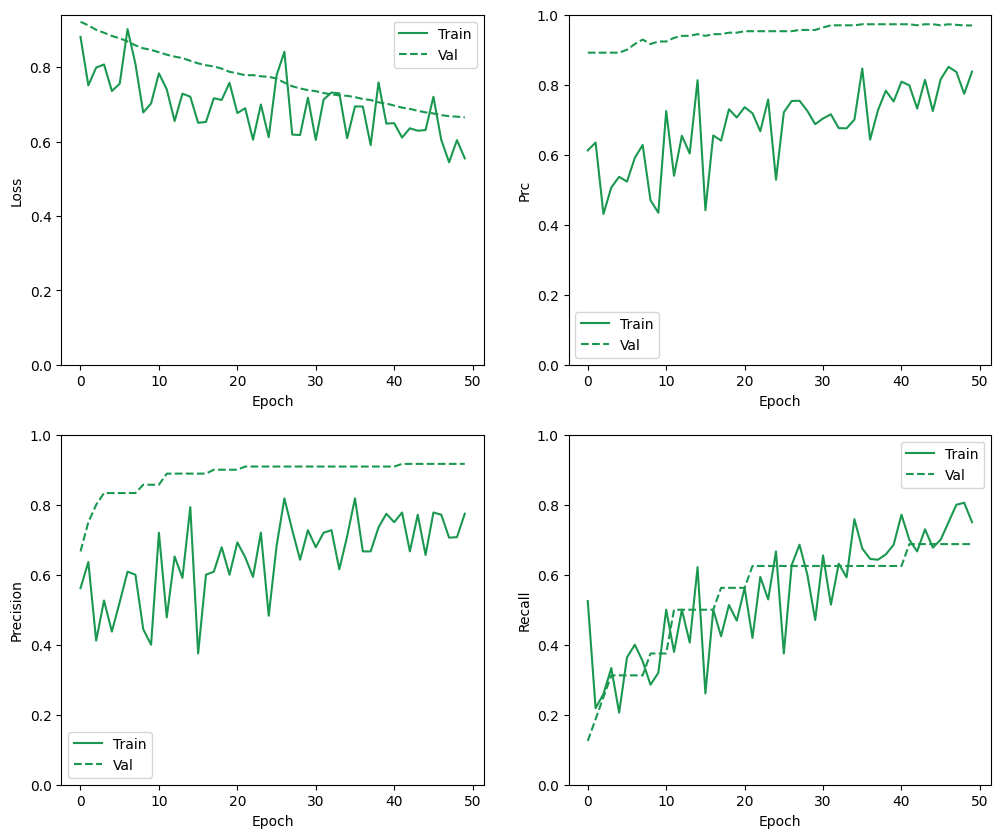

In [ ]:
plot_metrics(resampled_history)

3/3 [==============================] - 0s 3ms/step
loss :  0.6650513410568237
cross entropy :  0.6650513410568237
Brier score :  0.23497724533081055
tp :  11.0
fp :  1.0
tn :  1.0
fn :  5.0
accuracy :  0.6666666865348816
precision :  0.9166666865348816
recall :  0.6875
auc :  0.78125
prc :  0.9694368839263916

Legitimate Transactions Detected (True Negatives):  1
Legitimate Transactions Incorrectly Detected (False Positives):  1
Fraudulent Transactions Missed (False Negatives):  5
Fraudulent Transactions Detected (True Positives):  11
Total Fraudulent Transactions:  16


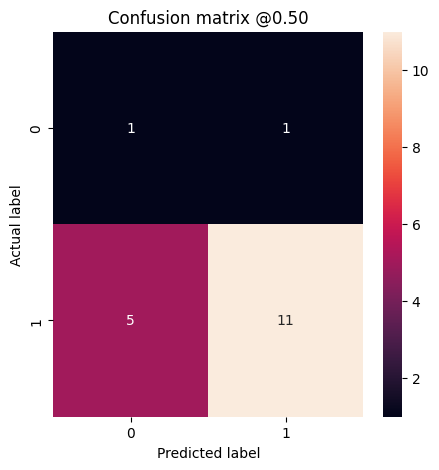

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()
plot_cm(test_labels, test_predictions_resampled)


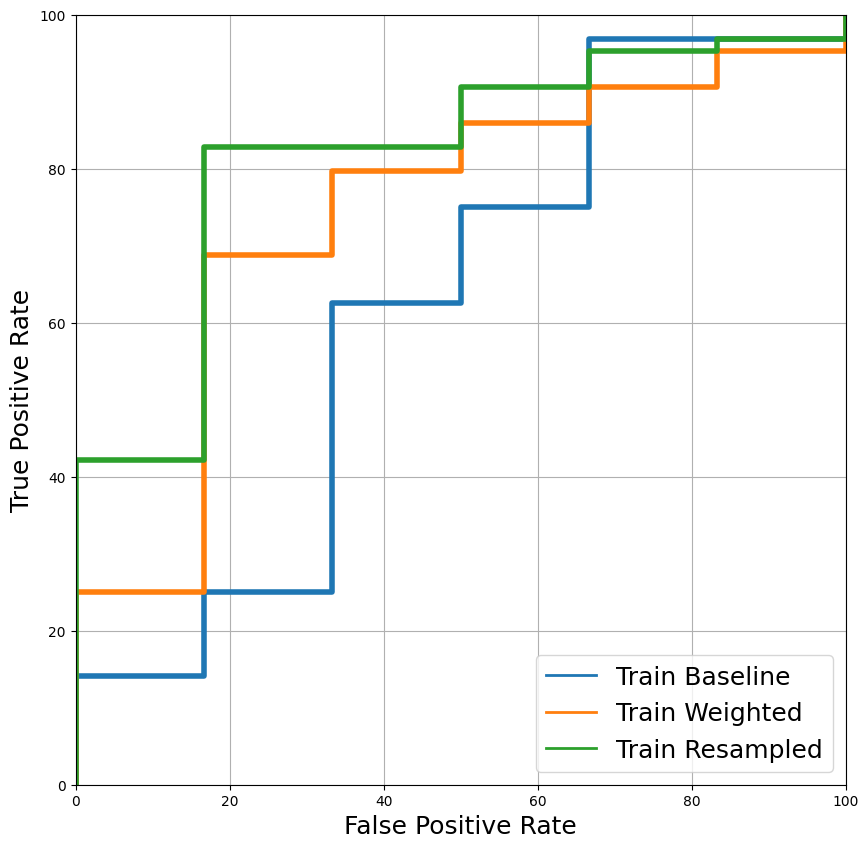

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])

# Adjust the legend and line properties
plt.legend(loc='lower right', prop={'size': 18})  # Increase the legend font size
plt.xlabel('False Positive Rate', fontsize=18)   # Adjust the x-axis label font size
plt.ylabel('True Positive Rate', fontsize=18)    # Adjust the y-axis label font size

# Adjust the line thickness
for line in plt.gca().lines:
    line.set_linewidth(4.0)  # Increase the line thickness

# Show the plot
plt.show()
